# LLM Society Advanced Tutorial

This tutorial demonstrates advanced features:
- Segment-based personas with custom names, and grouping by traits/segment
- LLM-driven scoring and interventions
- Building personas from a custom NetworkX graph's node attributes
- Exporting results
- Simple/complex contagion modes (no LLM)
- Centrality vs score, and animation


In [ ]:
import os
os.environ['OPENAI_API_KEY'] = "<YOUR_OPENAI_API_KEY>"

In [2]:
from llm_society.api import network
from llm_society.viz import set_theme

set_theme()  # publication-ready visuals


## 1) Segments with names; group by traits and by segment


In [3]:
seg_config = [
    {"name": "High-Dem", "proportion": 0.5, "traits": {"political": {"choices": {"Democrat": 0.7, "Republican": 0.3}}}},
    {"name": "High-Rep", "proportion": 0.5, "traits": {"political": {"choices": {"Democrat": 0.3, "Republican": 0.7}}}},
]

Round 0 summary: Most ratings judged this claim as not credible, with only a minority giving it high credibility.

=== Conversation 1 <-> 2 ===
1: Sounds good to me! What's on your mind today?
2: Hey! Not much, just kind of enjoying a chill day. How about you? Anything interesting going on?
(No information discussed; scores unchanged.)
=== End Conversation 1 <-> 2 ===


=== Conversation 4 <-> 6 ===
4: I’ve heard about microplastics being harmful, but I’m not sure there’s solid proof that they cause severe memory loss. It’s one of those things people talk about a lot, but the science isn’t totally clear yet.
6: Yeah, I get what you mean. There’s a lot of talk about microplastics, but I haven’t seen clear proof that they actually cause severe memory loss either.
=== End Conversation 4 <-> 6 ===

Score update 4<->6: 4 0.00 -> 0.00, 6 0.00 -> 0.00

=== Conversation 5 <-> 7 ===
5: Sounds good to me! What's been on your mind lately?
7: Honestly, I've been thinking a lot about how fast this y

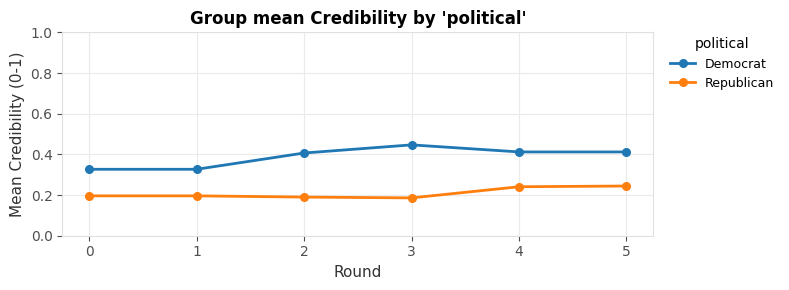

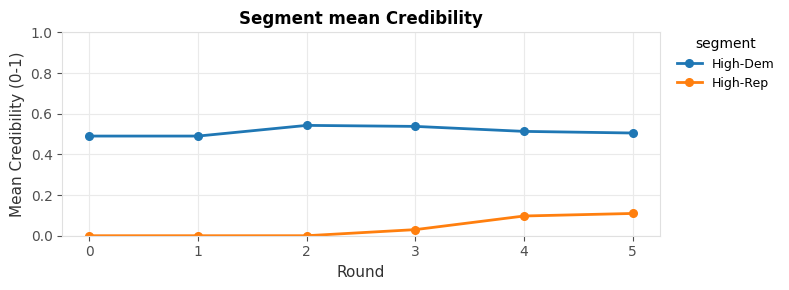

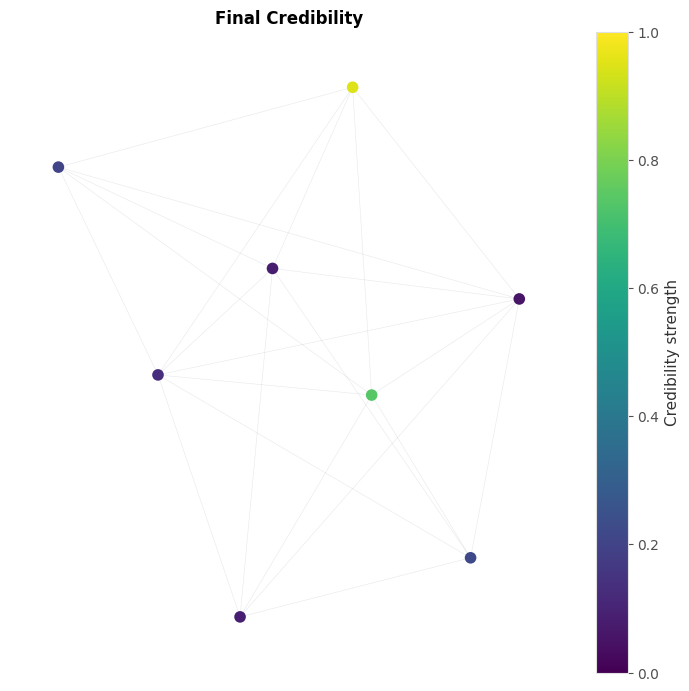

In [ ]:
net_seg = network(
    information="Microplastics cause severe memory loss.",
    n=8, degree=5, rounds=5,
    segments=seg_config,
    talk_prob=0.25,
    mode="llm",
    rng=7,
)

net_seg.simulate()
print(net_seg.summary_report())

# Group by trait
net_seg.plot(type="group", by="traits", attr="political", groups=["Democrat", "Republican"])
# Group by segment name (auto-detected from 'name')
net_seg.plot(type="group", by="segment")
# Final scores
net_seg.plot(type="final_scores")


## 2) Interventions
Inject instructions to selected agents from a specified round, and visualize mean score changes (trait-split).

Round 0 summary: Most people rated the claim's credibility very low, with a few higher ratings pulling up the average.

=== Conversation 0 <-> 4 ===
0: Totally fine with me. What do you feel like talking about?
4: Hey, thanks for asking! Honestly, I’m good with whatever—you want to talk about sports, politics, or just what’s new?
(No information discussed; scores unchanged.)
=== End Conversation 0 <-> 4 ===


=== Conversation 1 <-> 6 ===
1: Sure, sounds good! What’s on your mind today?
6: Hey! Not much, just enjoying a little break. How’s your day going so far?
1: Hey! My day’s been pretty good, nothing too crazy. Just trying to keep up with everything—how about you, anything fun during your break?
6: Hey! My day’s been chill too, just did some reading and caught up on a couple of shows. Sometimes a low-key day is the best, right?
1: Totally agree, I love those relaxing days where you can just unwind and not worry about anything. What shows are you watching lately?
6: Right now I’m rew

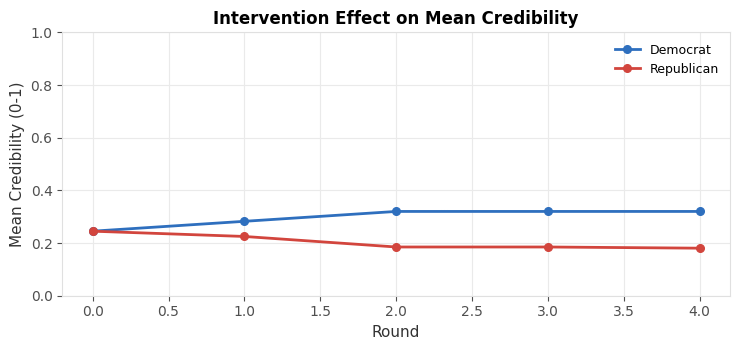

In [4]:
net_int = network(
    information="A new diet eliminates migraines.",
    n=8, degree=4, rounds=4,
    segments=seg_config,
    talk_prob=0.3,
    intervention_round=2,
    intervention_nodes=list(range(6)),  # target first 6 nodes
    intervention_content="You are reminded to be skeptical; demand strong evidence before agreeing.",
    rng=9,
)

net_int.simulate()
net_int.plot(type="intervention_effect", intervention_round=6, attr="political", groups=["Democrat", "Republican"])


## 3) Personas from a custom NetworkX graph (no segments)
When you pass a `graph` and omit `segments`, personas are constructed from node attributes.


Round 0 summary: Most credibility ratings are low, with the majority falling at or below the lower end of the scale.

=== Conversation 1 <-> 2 ===
1: Honestly, I think AI tutors really do make a difference. They can personalize lessons and give instant feedback, which helps people learn better.
2: Yeah, I totally see your point, but I haven’t really seen convincing proof that AI tutors actually improve how much people learn. I feel like they might help, but I’m not really sold on them being a huge game changer yet.
=== End Conversation 1 <-> 2 ===

Score update 1<->2: 1 0.98 -> 0.96, 2 0.00 -> 0.03
Round 1: 3/6 exposed/scoring > 0
Round 1 summary: Most credibility ratings for the claim are low, with only a minority rating it highly.

=== Conversation 1 <-> 2 ===
1: Sure, I’m up for whatever. What’s been on your mind lately?
2: Lately I’ve just been thinking about how quickly this year is flying by. Feels like summer just started, but it's basically halfway over already!
1: I know, righ

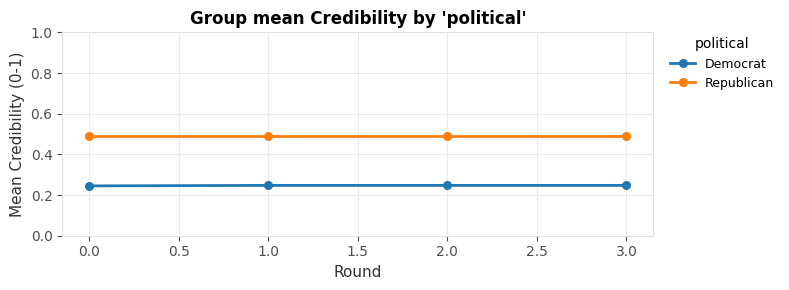

In [6]:
import networkx as nx

G = nx.gnp_random_graph(6, 0.12, seed=3)
for u, v in G.edges():
    G[u][v]["weight"] = 0.25  # tie strength
# Assign node attributes used to build personas
for i in G.nodes():
    G.nodes[i]["political"] = "Democrat" if (i % 3) else "Republican"
    G.nodes[i]["age"] = 25 + (i % 20)
    G.nodes[i]["gender"] = "Man" if (i % 2) else "Woman"

net_g = network(information="AI tutors improve learning outcomes.", graph=G, rounds=3, talk_prob=0.35, rng=11)
net_g.simulate()
# Group by trait without segments
net_g.plot(type="group", by="traits", attr="political")


## 4) Export results


In [8]:
net_int.export(
    history_csv="adv_history.csv",
    beliefs_csv="adv_scores_by_round.csv",  # backward-compatible argument name
    conversations_jsonl="adv_conversations.jsonl",
)
print("Exported: adv_history.csv, adv_scores_by_round.csv, adv_conversations.jsonl")


Exported: adv_history.csv, adv_scores_by_round.csv, adv_conversations.jsonl


## 5) Simple and complex contagion modes (no LLM)
Exposure spreads via neighbors; scores jump to seed level when exposed.


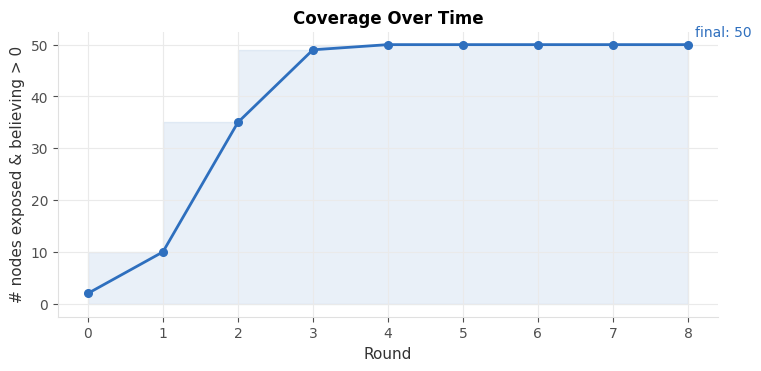

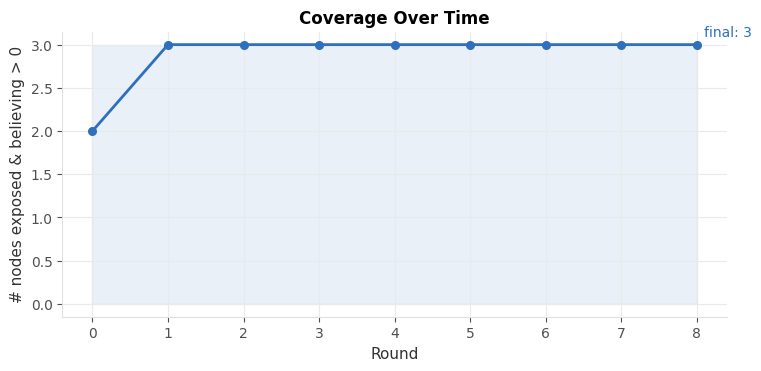

In [9]:
net_simple = network(information="Coffee helps focus.", n=50, degree=5, rounds=8, mode="simple", rng=21)
net_simple.simulate()
net_simple.plot(type="coverage")

net_complex = network(information="Coffee helps focus.", n=50, degree=5, rounds=8, mode="complex", complex_k=2, rng=22)
net_complex.simulate()
net_complex.plot(type="coverage")


## 6) Centrality vs score, and animation
- Use degree/betweenness/eigenvector centrality
- Show an animation of score evolution (JS in notebooks)
- Optionally save to mp4/gif/html (mp4 needs ffmpeg)


/opt/anaconda3/lib/python3.12/site-packages/llm_society/viz.py:466: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


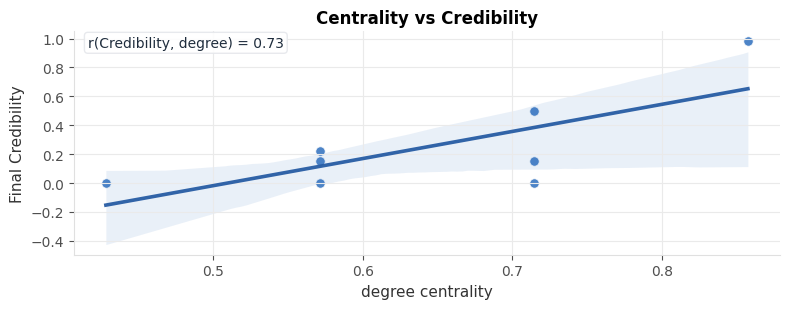

In [5]:
# Centrality vs score/exposure for net_seg
net_int.plot(type="centrality", metric="degree")

In [6]:
# Animation using viz directly
from llm_society import viz
ani = viz.show_animation(net_int.history, net_int.graph, interval_ms=600, figsize=(6, 6), metric_label=net_int.metric_name.capitalize())
# Save (uncomment to write a file; mp4 needs ffmpeg)
# viz.save_animation(ani, "adv_animation.mp4")
# viz.save_animation(ani, "adv_animation.gif")
# viz.save_animation(ani, "adv_animation.html")
